In [16]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal

dr = '/Users/colinwageman/Desktop/School/Cogs199/Recordings/Speller/'
file_1 = 'run_03.xdf'
file_2 = 'run_04.xdf'

# file 'run_03' contains data for spelling 'QUICK'
# file 'run_04' contains data for spelling 'P3EEG'

In [17]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']

def speller_file_to_dict(data):
    run = {
        'data': [],
        'time_stamps': [],
        'aux': [],
        'aux_time_stamps': [],
        'markers': [],
        'marker_time_stamps': [],
        'sample_rate': {},
    }
    for stream in data:
        if stream['info']['name'][0] == 'eeg_data':
            run['data'] = stream['time_series']
            run['time_stamps'] = stream['time_stamps']
            run['sample_rate']['eeg'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'aux_data':
            run['aux'] = stream['time_series']
            run['aux_time_stamps'] = stream['time_stamps']
            run['sample_rate']['aux'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'P300_Speller_Markers':
            run['markers'] = stream['time_series']
            run['marker_time_stamps'] = stream['time_stamps']
        else:
            print('Warning unmatched stream name')
            
    return run

data = {
    'run': [],
}

for file_nm in [file_1, file_2]:
    imported_data, _ = pyxdf.load_xdf(dr+file_nm)
    run = speller_file_to_dict(imported_data)
    data['run'].append(run)
    
print(data)

{'run': [{'data': array([[-105673.70571777,   35751.61525626,   37462.14955594, ...,
          32388.97411692,   34473.40839784,   37233.33474795],
       [-105696.59390409,   35750.34120683,   37457.00865471, ...,
          32386.73894247,   34467.52988905,   37229.87022756],
       [-105685.37332837,   35747.05550039,   37457.16511693, ...,
          32405.00031769,   34469.98858094,   37225.51163739],
       ...,
       [ -96755.9631772 ,   39976.96667635,   35866.68203672, ...,
          31614.93320643,   33907.5963387 ,   35376.19535639],
       [ -96774.38101463,   39969.52354545,   35855.32735054, ...,
          31604.561997  ,   33895.34758274,   35371.25562087],
       [ -96802.9241923 ,   39968.16008904,   35852.6451412 , ...,
          31596.29185156,   33889.60318441,   35369.5121848 ]]), 'time_stamps': array([1417.9418356 , 1417.9458356 , 1417.94983561, ..., 1669.517964  ,
       1669.521964  , 1669.525964  ]), 'aux': array([[ 417.,    8., 1020.],
       [ 417.,    8., 101

In [87]:
def filter_eeg(ch_datas, sample_rate, f_range):
    nyq = 0.5 * FREQ
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, ch_datas, axis=0)    
    
    return np.array(sig_filt)

In [47]:
def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel is not None else 'Time'
    ylabel = ylabel if ylabel is not None else 'Amplitude'
    title = title if title is not None else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend()
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
#             if (marker[0] == '1'):
            if '[' in marker[0]:
                ax.axvline(x=timestamp, color='C1')

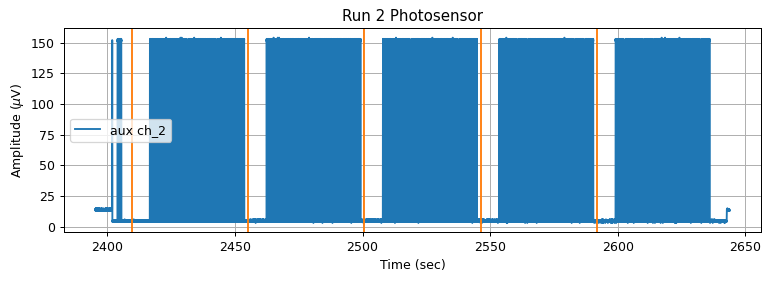

In [48]:
run_2 = data['run'][1]
fig, ax = plot_time_series(
    X = run_2['aux_time_stamps'],
    Y = run_2['aux'][:,1:2],
    labels = aux_chs[1:2],
    xlabel='Time (sec)',
    ylabel=r'Amplitude ($\mu$V)',
    title='Run 2 Photosensor'
)
add_markers_to_plot(run_2['markers'], run_2['marker_time_stamps'], fig, ax)

### Scale Photosensor
During the first run the screen brightness wasn't as it's brightest. Here I scale it up so as to use the same threshold for each.

In [35]:
max_run1 = max(data['run'][0]['aux'][:,1])
max_run2 = max(data['run'][1]['aux'][:,1])
scaler = max_run2/max_run1
data['run'][0]['aux'][:,1] = data['run'][0]['aux'][:,1] * scaler

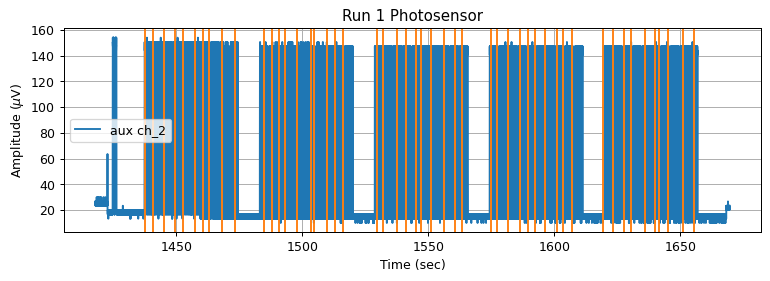

In [46]:
run_1 = data['run'][0]
fig, ax = plot_time_series(
    X = run_1['aux_time_stamps'],
    Y = run_1['aux'][:,1:2],
    labels = aux_chs[1:2],
    xlabel='Time (sec)',
    ylabel=r'Amplitude ($\mu$V)',
    title='Run 1 Photosensor'
)
add_markers_to_plot(run_1['markers'], run_1['marker_time_stamps'], fig, ax)

In [50]:
def get_samples_for_t_range(time_series, time_stamps, t_range, inclusive=False):
    if inclusive:
        low_filt = time_stamps >= t_range[0]
    else:
        low_filt = time_stamps > t_range[0]
        
    high_filt = time_stamps < t_range[1]
    index_range = low_filt == high_filt
    data_range = time_series[index_range]
    ts_range = time_stamps[index_range]
    return data_range, ts_range

In [130]:
# Filtering in Hz
FREQ = 250.0 # sample rate
LOWCUT = 0.1
HIGHCUT = 15.0

freq_range = [LOWCUT,HIGHCUT]
eeg_filtered = filter_eeg(run_1['data'], FREQ, freq_range)
eeg_ts = run_1['time_stamps']
# eeg_filtered = eeg_filtered.T
# eeg_filtered.shape

# Epoch durations in sec
PRE_STIM = 0.250
POST_STIM = 0.800
PS_THRESHOLD = 70

answer_key = {
    'Q': [3, 11],
    'U': [4, 9],
    'I': [2, 9],
    'C': [1, 9],
    'K': [2, 11],
    'P': [3, 10],
    '3': [5, 11],
    'E': [1, 11],
    'G': [2, 7],    
}
letter_ts = []
group_labels = []
for i, marker in enumerate(run_1['markers']):
#     print(marker)
    if '[' in marker[0]:
        lbl = marker[0].split('[')[1].split(']')[0]
        group_labels.append(lbl)
        letter_ts.append(run_1['marker_time_stamps'][i])

# don't forget the last letter
letter_ts.append(run_1['aux_time_stamps'][-1])
print(group_labels)
print(letter_ts)
sp_markers = []
aux_for_sp_markers = []
for i in range(1, len(letter_ts)):
    t_range = [letter_ts[i-1],letter_ts[i]]
    dr, dr_ts = get_samples_for_t_range(np.array(run_1['markers']), run_1['marker_time_stamps'], t_range)
    a_tup = get_samples_for_t_range(run_1['aux'], run_1['aux_time_stamps'], t_range)
    sp_markers.append(dr)
    aux_for_sp_markers.append(a_tup)

sp_markers = np.array(sp_markers).reshape((5,120))
# print(sp_markers)

# Conver AUX Data to binary 1 at the start of stim
onset_ts = []
for aux_set_data, aux_set_ts in aux_for_sp_markers:
    ltr_group = []
    for i in range(1,len(aux_set_data)):
        val = int(aux_set_data[i,1] >= PS_THRESHOLD)
        prev = int(aux_set_data[i-1,1] >= PS_THRESHOLD)
        t = aux_set_ts[i]
        if (val-prev == 1):
            ltr_group.append(t)
            
    onset_ts.append(ltr_group)

onset_ts = np.array(onset_ts)
# stim_labels = np.array(marker_data).flatten()
# print('Number of stimuli match number of markers:', len(onset_ts) == len(stim_labels))

target_stim_epochs = []
non_target_stim_epochs = []
target_stim_ps_epochs = []
non_target_stim_ps_epochs = []

for onsets, labels, key in zip(onset_ts, sp_markers, group_labels):
    for ts, label in zip(onsets, labels):
        epoch_start = ts - PRE_STIM
        epoch_end = ts + POST_STIM
    #     print(epoch_start, epoch_end)
        # exclude raw ref channel at index 0
        epoch_tuple = get_samples_for_t_range(eeg_filtered, eeg_ts, [epoch_start, epoch_end])
        sensor_tuple = get_samples_for_t_range(run_1['aux'][:,1], run_1['aux_time_stamps'], [epoch_start, epoch_end+.004])
        
        ans = answer_key[key]
#         print(key, ans)
        if int(label) in ans:
            target_stim_epochs.append(epoch_tuple)
            target_stim_ps_epochs.append(sensor_tuple)
        else:
            non_target_stim_epochs.append(epoch_tuple)
            non_target_stim_ps_epochs.append(sensor_tuple)

print(f'{len(non_target_stim_epochs)} Non-Target Epochs and {len(target_stim_epochs)} Target Epochs')

['Q', 'U', 'I', 'C', 'K']
[1430.3499513482054, 1476.03514164977, 1521.554616875919, 1567.0840907582742, 1612.6285559889382, 1669.5259665445276]
500 Non-Target Epochs and 100 Target Epochs


In [131]:
def ms_to_samples(duration, rate=250):
    return round((duration/1000.0) * 250.0)

def baseline_center(eeg_event_ch, baseline_duration):
    baseline_samples = ms_to_samples(baseline_duration)
    base_avg = np.mean(eeg_event_ch[0:baseline_samples])
    baseline_centered = eeg_event_ch - base_avg
    return baseline_centered

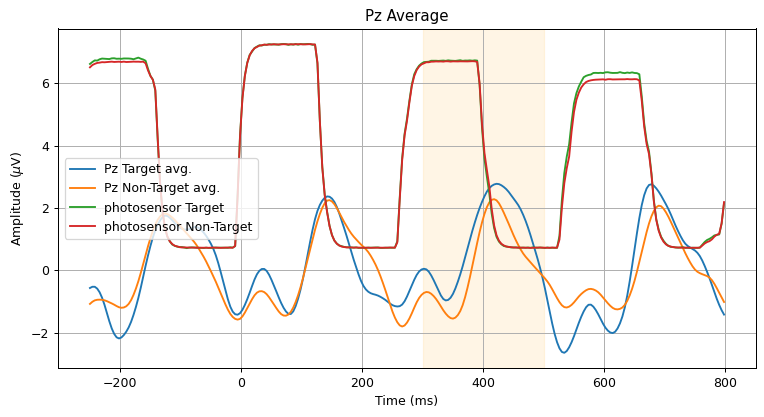

In [139]:
# channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
chan_index = 4
ch_label = channels[chan_index]

test_x = [(i*4)-250 for i in range(len(target_stim_epochs[0][0]))]

Pz_odd_epochs = []
Pz_std_epochs = []
for eeg_event_data, eeg_event_ts in target_stim_epochs:
    b = baseline_center(eeg_event_data[:,chan_index], PRE_STIM*1000)
    Pz_odd_epochs.append(b)
    
for eeg_event_data, eeg_event_ts in non_target_stim_epochs:
    b = baseline_center(eeg_event_data[:,chan_index], PRE_STIM*1000)
    Pz_std_epochs.append(b)
        
Pz_odd_epochs = np.array(Pz_odd_epochs)
# print(Pz_odd_epochs.shape)
Pz_std_epochs = np.array(Pz_std_epochs)
Pz_odd_epoch_avg = np.mean(Pz_odd_epochs, axis=0)
# print(Pz_odd_epoch_avg.shape)
Pz_std_epoch_avg = np.mean(Pz_std_epochs, axis=0)
odd_stim_ps_avg = np.mean(np.array(target_stim_ps_epochs)[:,0], axis=0)
# print(odd_stim_ps_avg.shape)
std_stim_ps_avg = np.mean(np.array(non_target_stim_ps_epochs)[:,0], axis=0)

fig, ax = plt.subplots(figsize = (10, 5), dpi = 90)
ax.axvspan(300, 500, color='orange', alpha=0.1)

ax.plot(test_x, Pz_odd_epoch_avg, label=f'{ch_label} Target avg.')
ax.plot(test_x, Pz_std_epoch_avg, label=f'{ch_label} Non-Target avg.')
ax.plot(test_x, odd_stim_ps_avg*0.05, label='photosensor Target')
ax.plot(test_x, std_stim_ps_avg*0.05, label='photosensor Non-Target')

ax.set_xlabel('Time (ms)')
ax.set_ylabel(r'Amplitude ($\mu$V)')
ax.set_title(f'{ch_label} Average')
ax.grid(True)
_ = ax.legend()